#### Yaelin's Note

* UID 별 로그 데이터 수를 기준으로 threshold를 줘야할까?
* 속도 향상 필요 - 정말 이게 의미가 있으려면, 실제 업에서 활용될 수 있으려면

In [1]:
import pandas as pd
import re
import numpy as np
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

## load data

In [2]:
import os
print(os.getcwd()) # 현재 디렉토리 확인

/home/da/jupyter/조예린/Recosys


In [3]:
sample = pd.read_csv("/home/da/jupyter/조예린/Recosys/data(다운로드금지)/0109_PC&Mob_06_가전제품구매.csv", low_memory=False)

In [ ]:
sample_uid = sample.UID.unique().tolist()

## url data preprocessing

In [4]:
url_list = sample.Full_URL.tolist()

In [5]:
def prep_url(url):
    prep_url = re.sub("[-=+,#/\?:^$.@*\"*~&!\\'|\(\)\[\]\<\>...]"," ",url)
    prep_url = re.sub("[%]","",prep_url)
    prep_url = prep_url.split(" ")
    prep_url = list(filter(lambda x: x != '', prep_url))
    return prep_url

In [6]:
prep_url_list = list(map(prep_url, url_list))

## Word embedding by Word2Vec

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
# size=3인 이유는 RGB 색상으로 나타내야 하기 때문
model = Word2Vec(sentences=prep_url_list, size=3, window=5, workers=4, sg=1)

In [ ]:
model.wv.save_word2vec_format("./model/word2vec_model") # 모델 저장
loaded_model=KeyedVectors.load_word2vec_format("./model/word2vec_model") # 모델 로드

In [ ]:
!python -m gensim.scripts.word2vec2tensor --input ./model/0112_word2vec_model --output ./model/0112_word2vec_model

## Word embedding by Sent2Vec

In [ ]:
from nltk import word_tokenize
import numpy as np

In [ ]:
url_vectorized = []
for i in prep_url_list:
    vectors = [loaded_model[w] for w in i if w in loaded_model]
    v = np.zeros(loaded_model.vector_size)
    if (len(vectors)>0):
        v = (np.array([sum(x) for x in zip(*vectors)])) / v.size
    url_vectorized.append(v)

## 시각화를 위한 데이터 정리

In [ ]:
url_vct_tup = list(map(tuple, url_vectorized))

In [ ]:
# RGB 벡터 데이터프레임 만들기
vis_sample = pd.DataFrame(url_vct_tup, columns=["color_R","color_G","color_B"])

In [ ]:
# 기존 sample 데이터프레임 + RGB 벡터 테이터프레임
vis_sample = pd.concat([sample[["UID","Full_URL","Time","PC"]],vis_sample], axis=1)

In [ ]:
# 로그 찍힌 시간 데이터타입 datetime64로 지정
vis_sample["Time"] = vis_sample["Time"].astype("datetime64")

In [ ]:
# Time -> date, time 나누기
vis_sample["date"] = vis_sample["Time"].dt.strftime("%d")
vis_sample["time"] = vis_sample["Time"].dt.time

In [ ]:
# date 컬럼, int로 type 변경
vis_sample["date"] = vis_sample["date"].astype("int")

In [ ]:
# 데이터프레임 저장 및 불러오기
vis_sample.to_csv("./data(다운로드금지)/0114_PC&Mob_06_가전제품구매_withRGB.csv", index=False)

vis_sample = pd.read_csv("./data(다운로드금지)/0114_PC&Mob_06_가전제품구매_withRGB.csv", low_memory=False)
vis_sample["Time"] = vis_sample["Time"].astype("datetime64")

## 초단위 기준 데이터프레임 생성

In [18]:
# 초단위 기준 데이터프레임 생성
# 맨 마지막 행이 7월 1일이라, 이건 추후 삭제
everysec = pd.date_range(start=pd.Timestamp('2014-06-01 00:00:00'), end=pd.Timestamp('2014-07-01 00:00:00'), freq='S')
everysec_df = pd.DataFrame(everysec)
everysec_df.columns = ['Time']

## log2image function

In [19]:
def log2image(uid):
    file_name = "./image/" + str(uid) + "_6월_가전제품"
    temp = vis_sample[vis_sample.UID==uid].copy()
    temp.sort_values(by="Time", inplace=True)
    temp.reset_index(drop=True, inplace=True)
    
    temp_everysec = everysec_df.merge(temp[["Time","Full_URL",
                                            "color_R","color_G","color_B"]], how='left')    
    temp_everysec["date"] = temp_everysec["Time"].dt.strftime("%d")
    temp_everysec["date"] = temp_everysec["date"].astype("int")
#     print(temp_everysec[temp_everysec["color_R"].notnull()].head())
    
    temp_everysec["color_R"] = temp_everysec["color_R"].apply(lambda x: 0 if np.isnan(x) else x)
    temp_everysec["color_G"] = temp_everysec["color_G"].apply(lambda x: 0 if np.isnan(x) else x)
    temp_everysec["color_B"] = temp_everysec["color_B"].apply(lambda x: 0 if np.isnan(x) else x)
    
    temp_everysec.drop(temp_everysec.tail(1).index,inplace=True)
    print("시각화를 위한 데이터프레임 생성 완료")
    
    limits = []
    for i in range(1, 31):
        limits.append(len(temp_everysec[temp_everysec["date"]==i]))
    print(max(limits))
        
    r = np.zeros((30,max(limits)))
    g = np.zeros((30,max(limits)))
    b = np.zeros((30,max(limits)))
    
    r_element = list()
    g_element = list()
    b_element = list()

    for i in range(1, 31):
        r_element.append([y for idx, y in enumerate(temp_everysec.color_R) if temp_everysec.iloc[idx,-1]==i])
        g_element.append([y for idx, y in enumerate(temp_everysec.color_G) if temp_everysec.iloc[idx,-1]==i])
        b_element.append([y for idx, y in enumerate(temp_everysec.color_B) if temp_everysec.iloc[idx,-1]==i])
        
    for i in range(0, 30):
        for j in range(0, len(r_element[i])):
            r[i][j] = r_element[i][j]
            g[i][j] = g_element[i][j]
            b[i][j] = b_element[i][j]
    
    print("시각화를 위한 RGB Array 생성 완료")

    fig = plt.figure(figsize=(20,10))
    ny, nx = 30, max(limits)

    c = np.dstack([r,g,b])
    
    plt.axis('off')
    plt.imshow(c, interpolation='nearest', aspect='auto')
    plt.savefig(file_name, bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()
    print("시각화된 이미지 저장 완료")
    return r,g,b

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.6/logging/__init__.py", line 998, in emit
    self.flush()
  File "/usr/lib/python3.6/logging/__init__.py", line 978, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/lib/python3/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib/python3/dist-packages/tornado/ioloop.py", line 888, in s

                     Time                                           Full_URL  \
39892 2014-06-01 11:04:52                                http://m.naver.com/   
39895 2014-06-01 11:04:55  http://m.search.naver.com/search.naver?where=m...   
39913 2014-06-01 11:05:13                                http://m.naver.com/   
39933 2014-06-01 11:05:33  http://m.news.naver.com/photoViewer.nhn?compon...   
39996 2014-06-01 11:06:36                                http://m.naver.com/   

        color_R   color_G   color_B  date  
39892  2.565616 -0.929637  1.864298     1  
39895  7.296415 -1.808982  9.808392     1  
39913  2.565616 -0.929637  1.864298     1  
39933  9.510301 -2.944537  9.701979     1  
39996  2.565616 -0.929637  1.864298     1  
시각화를 위한 데이터프레임 생성 완료
86647


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


시각화를 위한 RGB Array 생성 완료


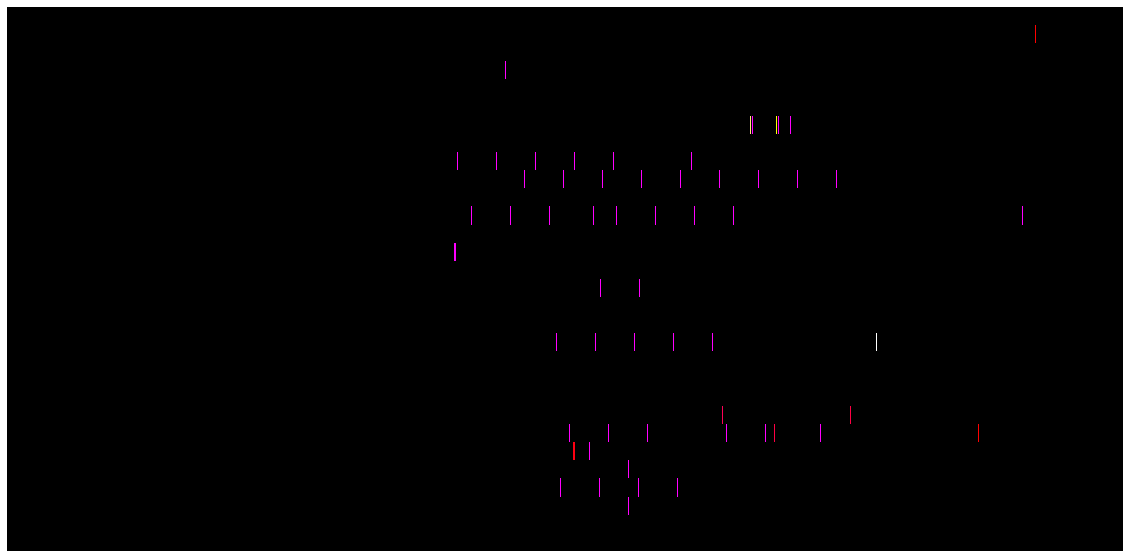

시각화된 이미지 저장 완료
(30, 86647)
(30, 86647)
(30, 86647)
                  Time                                           Full_URL  \
86 2014-06-01 00:01:26      http://www.ppomppu.co.kr/banner/bbs_list.html   
87 2014-06-01 00:01:26         http://www.ppomppu.co.kr/banner/right.html   
88 2014-06-01 00:01:26       http://www.ppomppu.co.kr/banner/top_sub.html   
89 2014-06-01 00:01:27  http://p4-cbxcyljaoqpie-ir7k3znkyo6ts5hd-if-v6...   
90 2014-06-01 00:01:27  http://imp.sndkorea.co.kr/imp/gate.php?target=...   

      color_R    color_G   color_B  date  
86   5.972191   1.056297 -1.271554     1  
87   5.947385   0.917914 -1.427711     1  
88   6.227267   1.153570 -1.608918     1  
89  12.375785   9.435825 -5.279121     1  
90  16.686443  10.689944 -6.103130     1  
시각화를 위한 데이터프레임 생성 완료
88907


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


시각화를 위한 RGB Array 생성 완료


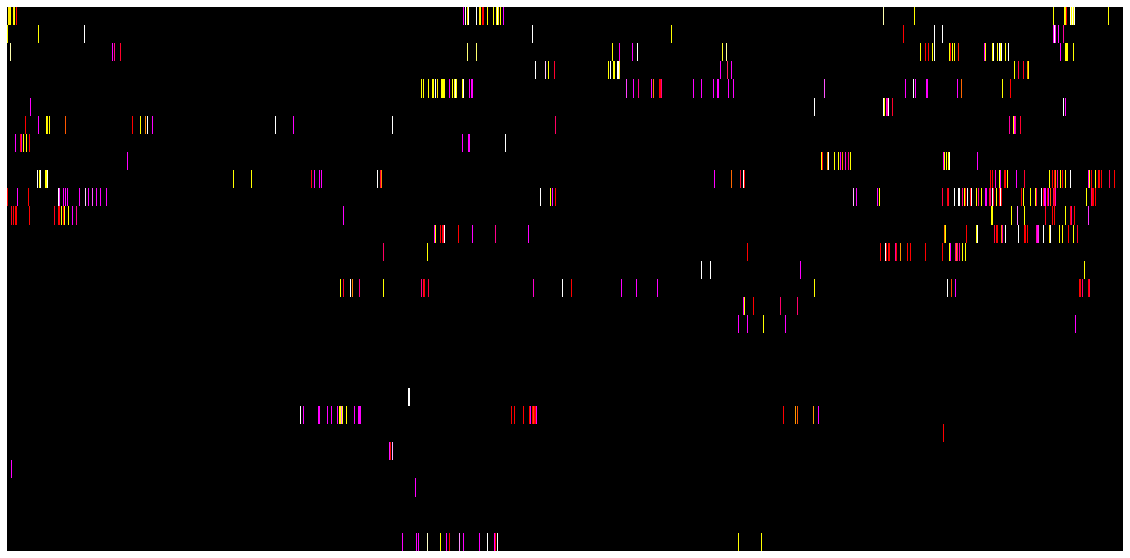

시각화된 이미지 저장 완료
(30, 88907)
(30, 88907)
(30, 88907)
                      Time                                           Full_URL  \
116478 2014-06-02 08:21:18  http://nateonevent.nate.com/popup/ad_login/rol...   
116502 2014-06-02 08:21:42               http://xo.nate.com/nateon/NtLogin.sk   
116503 2014-06-02 08:21:42                      https://br.nate.com/index.php   
126907 2014-06-02 11:15:06  https://wbill.samsungcard.com/ehub/rpc/LSECCom...   
126908 2014-06-02 11:15:06                 https://wbill.samsungcard.com/ehub   

         color_R   color_G   color_B  date  
116478  6.970611 -2.274181  0.875526     2  
116502  5.851276 -2.824512  3.190541     2  
116503  4.680691 -1.258816  1.703937     2  
126907  5.292863 -2.026949  0.700718     2  
126908  4.250911 -1.669531  0.612804     2  
시각화를 위한 데이터프레임 생성 완료
86514


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


시각화를 위한 RGB Array 생성 완료


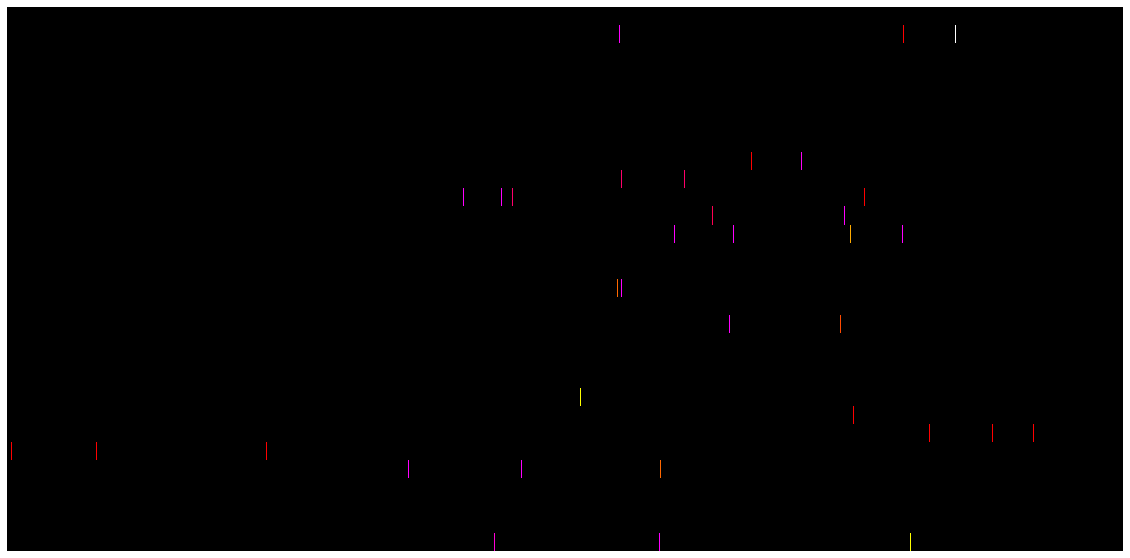

시각화된 이미지 저장 완료
(30, 86514)
(30, 86514)
(30, 86514)
                       Time  \
1795606 2014-06-21 18:46:46   
1795618 2014-06-21 18:46:58   
1795630 2014-06-21 18:47:10   
1795906 2014-06-21 18:51:46   
1795910 2014-06-21 18:51:50   

                                                  Full_URL    color_R  \
1795606    http://www.processclean.co.kr/ads/tads/ad5.html   5.861557   
1795618  http://cc.naver.com/cc?a=ncy.sports&r=&i=&bw=1...  19.743734   
1795630        http://sports.news.naver.com/main/index.nhn   6.435934   
1795906  http://cc.naver.com/cc?a=LNB.baseball&r=&i=bas...  20.560719   
1795910  http://sports.news.naver.com/sports/index.nhn?...   7.877873   

          color_G    color_B  date  
1795606  2.475401  -1.603876    21  
1795618  0.085894  23.080136    21  
1795630 -2.461602   4.089351    21  
1795906 -1.254067  23.542948    21  
1795910 -2.524546   5.854916    21  
시각화를 위한 데이터프레임 생성 완료
86537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


시각화를 위한 RGB Array 생성 완료


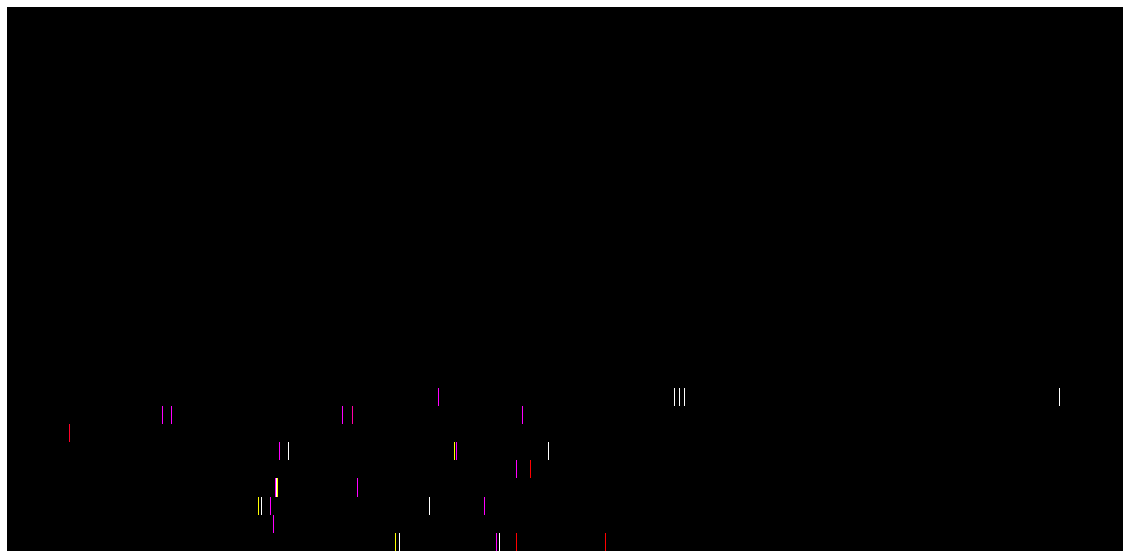

시각화된 이미지 저장 완료
(30, 86537)
(30, 86537)
(30, 86537)
                   Time                                    Full_URL   color_R  \
230 2014-06-01 00:03:50  http://sportstv.afreeca.com/etc/replay.php  4.444254   
238 2014-06-01 00:03:58  http://sportstv.afreeca.com/etc/replay.php  4.444254   
240 2014-06-01 00:04:00  http://sportstv.afreeca.com/etc/replay.php  4.444254   
304 2014-06-01 00:05:04                     http://www.afreeca.com/  2.384815   
312 2014-06-01 00:05:12                http://sportstv.afreeca.com/  2.314652   

      color_G   color_B  date  
230 -0.331030  0.981413     1  
238 -0.331030  0.981413     1  
240 -0.331030  0.981413     1  
304 -0.602821  0.523176     1  
312 -0.707893  0.790533     1  
시각화를 위한 데이터프레임 생성 완료
86762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


시각화를 위한 RGB Array 생성 완료


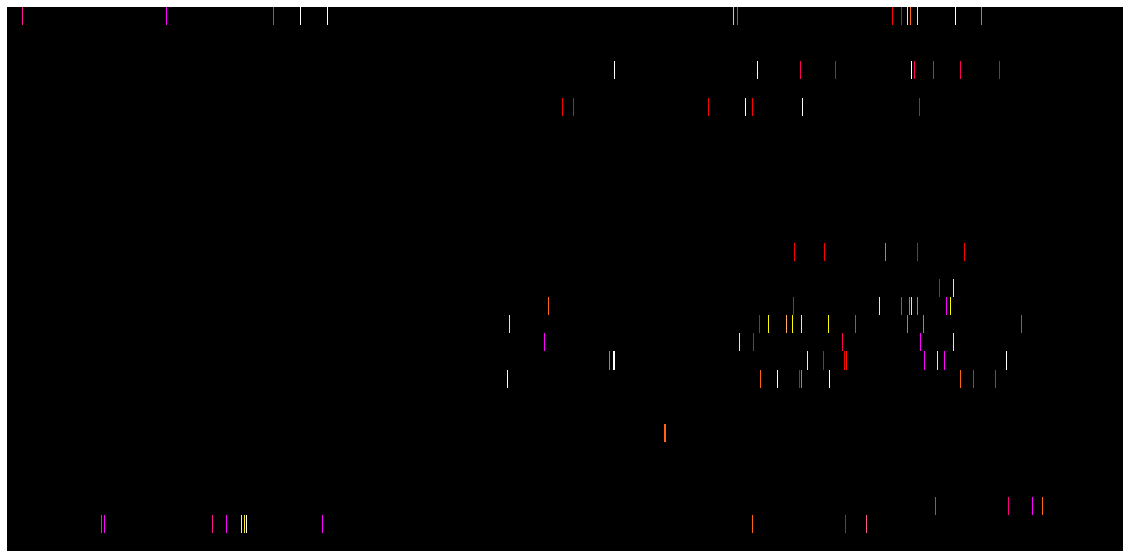

시각화된 이미지 저장 완료
(30, 86762)
(30, 86762)
(30, 86762)



In [21]:
for uid in tqdm_notebook(sample_uid):
    r,g,b = log2image(uid)
    print(r.shape)
    print(g.shape)
    print(b.shape)
    RGB_data.append((uid,r,g,b))